# Recommender System

This is a recommender system built with collaborative filtering for the movie lens dataset.

# Question 1

In [76]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def load_data():
    data = pd.read_csv('ml-latest-small/ratings.csv', 
                       names= ['userid', 'movieid', 'rating', 'timestamp'],
                       header=0)
    
    #create R matrix: rows=users, columns=movies
    R = data.pivot_table(index=['userid'], columns=['movieid'], values='rating', fill_value=0).values
    return R, data

R,data = load_data()
print(R.shape)

(671, 9066)


In [57]:
#Question 1
# total_num_users = 671
# total_num_ratings = 100004
# total_num_movies = 9125 # where did you get this number? get 9066 from R matrix
total_num_users, total_num_movies = R.shape
total_num_ratings = np.count_nonzero(R)

max_possible_ratings = total_num_users * total_num_movies

sparsity = total_num_ratings / max_possible_ratings

print(sparsity) # before 0.01633285017250883

0.016439141608663475


In [58]:
values, counts = np.unique(R, return_counts=True)
dict(zip(values, counts))

mults = values*counts
avg_rating = np.sum(mults)/np.sum(counts[1:])
print(avg_rating)

3.54360825567


# Question 2

Shown below is a plot of the number of ratings for each rating value. In the plot below, the number of sparse (0 entries) is omitted since it dwarfs the other values by more than an order of magnitude. There are 5983282 sparse entries.

Our calculated average rating was 3.544, not including the sparse ratings (0 values). From the graph below, it's clear that this makes sense. Most of the ratings are 4 star, but the lower ratings in the range of 0.5-2.5 bring this average down.

100004


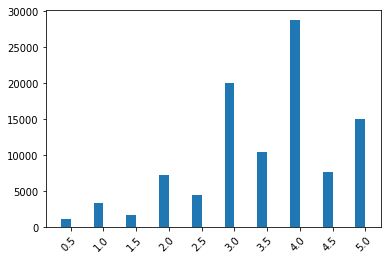

In [74]:
bins = values
ax = plt.subplot(111)
width = 0.3

index = np.arange(len(values[1:]))
ax.bar(index, counts[1:], width=width)

ax.set_xticks(index + width/2)
ax.set_xticklabels(values[1:],rotation=45, rotation_mode="anchor", ha="right")

plt.show()

The plot below includes the sparse entries. The second largest category is 4 stars, which has 28750 entries. This is barely visible on the graph.

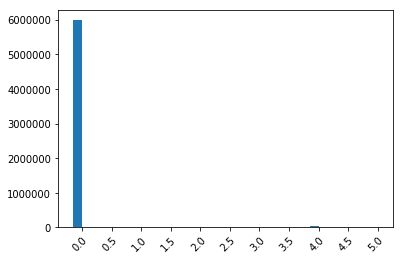

In [75]:
ax = plt.subplot(111)
width = 0.3

index = np.arange(len(values))
ax.bar(index, counts, width=width)

ax.set_xticks(index + width/2)
ax.set_xticklabels(values,rotation=45, rotation_mode="anchor", ha="right")

plt.show()

# Question 3
Plotting the distribution of movies. X-axis is the movie index in decreasing frequency and y-axis is the number of ratings the movie has.

In [109]:
#print(data)

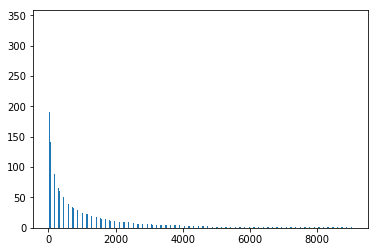

In [120]:
#print(R[:,0])
#print(R)

user_row, movie_col = R.shape
#print(user_row, movie_col)

distros = [np.count_nonzero(R[:,movie]) for movie in range(movie_col)]
#print(distros)

#decorate, sort, undecorate
movie_ids = np.arange(movie_col)
distros, movie_ids = zip(*sorted(zip(distros, movie_ids), reverse=True))

ax = plt.subplot(111)
width = 0.3

index = np.arange(len(movie_ids))
ax.bar(index, distros, width=width)

#ax.set_xticks(index + width/2)
#ax.set_xticklabels(movie_ids,rotation=45, rotation_mode="anchor", ha="right")

plt.show()
    

# Question 4
Plotting the distribution of users and their ratings in decreasing frequency. The X-axis is user index sorted by decreasing frequency and the y-axis is the number of movies that user has rated.

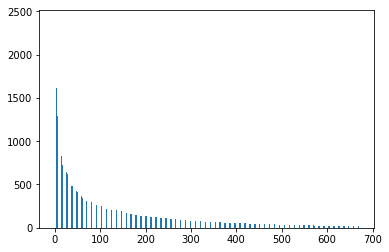

In [121]:
num_ratings_per_user = [np.count_nonzero(R[user,:]) for user in range(user_row)]
user_ids = np.arange(user_row)
num_ratings_per_user, user_ids = zip(*sorted(zip(num_ratings_per_user, user_ids), reverse=True))

ax = plt.subplot(111)
width = 0.3

index = np.arange(len(user_ids))
ax.bar(index, num_ratings_per_user, width=width)

#ax.set_xticks(index + width/2)
#ax.set_xticklabels(user_ids,rotation=45, rotation_mode="anchor", ha="right")

plt.show()

# Question 5
Explanation of the salient features of the distribution found in question 3 and implications for recommendation process.

Some movies are much more heavily reviewed than others. Since a user cannot review the same movie twice, we can assume that in the case where a movie has 671 reviews and there are 671 users, each user has reviewed the movie. Therefore, if we know our population size, the number of reviews that a movie has makes it a good indicator of population-wide preference. With collaborative filtering, we want to use commonalities in order to perform interpolation and fill in gaps. Since there is a lot of sparsity in this data, one reduction technique could be to remove movies that fall below a certain threshold of number of reviews. Movies with fewer reviews will cover less of the population spread and be less effective indicators of preference in the collaborative algorithm.

Concretely, question 3's plot shows that one movie had nearly 200 reviews, which spans approximately 29% of the population. Other movies had nearly 150 reviews, or nearly 22% of the population. Thus, these two movies would be excellent choices if we were required to only choose two members of the dataset.

# Question 6
Compute the variance of rating values received by each movie. 

# TODO DON'T FORGET TO DO THIS

In [52]:
R,data = load_data()

In [53]:
print(R.shape)

(671, 9066)


# Question 7
By summing over $r_{uk}$, we sum up all of the user's ratings. The denominator is the length of the set containing indices for the user's specified ratings. 

\begin{equation}
\frac{\Sigma_{i\in I_{u}} r_{uk}}{|I_{u}|} \forall u \in {1....m}
\end{equation}

# Question 8
$I_{u} \cap I_{v}$ represents the intersection of the two sets of indices for users u and v. Concretely, this intersection is the set containing the indices of items both users rated. It's possible for the intersection to be the empty set $\emptyset$ if two users have not rated any of the same movies. 

For example, let's say two users rate one movie each. User 1 rates Batman and User 2 rates Star Wars. The intersection of indices would be the empty  set ($I_{u} \cap I_{v} = \emptyset$).

# Question 9
We perform mean centering as a form of normalization. Without normalization, the approach would be to define a match/peer group as the set consisting of the k-nearest neighbors given highest Pearson correlation coefficient. However, since we're iterating over items that don't necessarily have the same number of ratings per user, there will be differences from iteration to iteration. If we return the weighted average of the ratings as the predicted rating for an item, an especially sparsely rated value (one rated by a single user) can be skewed if the user is biased. For example, a user may rate every movie with 5 stars. Conversly, a user may rate every movie with 0.5 stars. A biased user such as this would skew a sparse row of ratings and offset the prediction. Mean subtraction is performed in order to minimize the skew these types of users can have on predictions.

# Question 10
Design a k-NN collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Sweep k ( number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).


In [7]:
from surprise import KNNBasic, KNNWithMeans
from surprise import Dataset
from surprise.model_selection import cross_validate

data = Dataset.load_builtin('ml-100k')
ks = np.linspace(2, 100, num=50)
sim_options = {'name': 'pearson_baseline'}



In [8]:
%%capture
#run the sweeps
outputs = []
for k in ks:
    algo = KNNWithMeans(k=int(k), sim_options=sim_options)
    outputs.append(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10))
    

KeyboardInterrupt: 

In [28]:
avg_rmses = []
avg_maes = []
for output in outputs:
    #average the test_rmse
    avg_rmses.append(np.mean(output['test_rmse']))
    
    #average the test_mae
    avg_maes.append(np.mean(output['test_mae']))

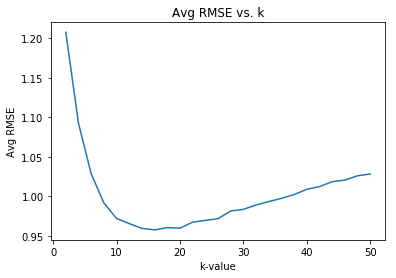

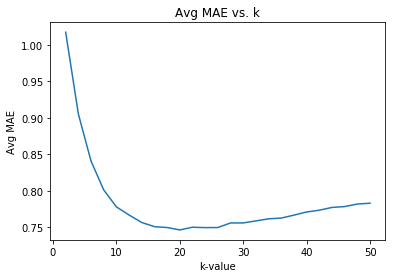

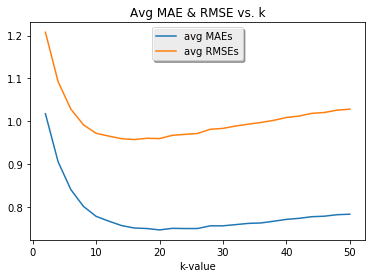

In [90]:
def plotStats(avg_rmses=None, avg_maes=None):
    if avg_rmses is not None:
        ax = plt.subplot(111)
        width = 2

        plt.title("Avg RMSE vs. k")
        plt.ylabel("Avg RMSE")
        plt.xlabel("k-value")
        ax.plot(ks, avg_rmses)
        plt.show()

    if avg_maes is not None:
        ax = plt.subplot(111)
        width = 2

        plt.title("Avg MAE vs. k")
        plt.ylabel("Avg MAE")
        plt.xlabel("k-value")
        ax.plot(ks, avg_maes)
        plt.show()

    if avg_rmses is not None and avg_maes is not None:
        ax = plt.subplot(111)
        width = 2

        plt.title("Avg MAE & RMSE vs. k")
        plt.xlabel("k-value")
        ax.plot(ks, avg_maes, label="avg MAEs")
        ax.plot(ks, avg_rmses, label="avg RMSEs")
        legend = ax.legend(loc='upper center', shadow=True)
        plt.show()

    
plotStats(avg_rmses=avg_rmses, avg_maes=avg_maes)

# Question 11: Find a "Minimum k"
Goal is to find the point at which increasing k does not result in a signficant decrease in average RMSE or average MAE.

In [92]:
import math

def euclidean_elbow(ks, curve, verbose=False):
    #get first point
    s_x, s_y = ks[0], curve[0]

    #get last point
    e_x, e_y = ks[len(ks)-1], curve[len(curve)-1]

   

    slope = (e_y-s_y)/float(e_x-s_x)
    b = s_y - slope*s_x
#    print(s_x, s_y)
#    print(e_x, e_y)
#    print(slope)
    #get midpoint
    m_idx = int((len(ks)/2)-1)
    x_mid = ks[m_idx]
    y_mid = slope*x_mid + b


    #iterate through all points along the curve
    distances = []
    for x, y in zip(ks, curve):
        #get the x and y points of the vector line
        y2 = e_y
        y1 = s_y
        x2 = e_x
        x1 = s_x
        x3 = x
        y3 = y
        
        k = ((y2-y1) * (x3-x1) - (x2-x1) * (y3-y1)) / ((y2-y1)**2 + (x2-x1)**2)
        x4 = x3 - k * (y2-y1)
        y4 = y3 + k * (x2-x1) 
        #calculate distance
        distance = math.sqrt((x-x4)**2 + (y-y4)**2)
        distances.append(distance)

    #find max distance
    max_dist_index = np.argmax(distances)
    if(verbose):
        print(distances)
        print("best k: ", ks[max_dist_index])




    return max_dist_index

In [100]:
mae_idx = euclidean_elbow(ks, avg_maes)
print("Best k for MAE is index: ", mae_idx, "  || best k-value: ", ks[mae_idx])

rmse_idx = euclidean_elbow(ks, avg_rmses)
print("Best k for RMSE is index: ", rmse_idx, " || best k-value: ", ks[rmse_idx])

print("Minimum K = %d" % max(ks[mae_idx], ks[rmse_idx])) # 16

Best k for MAE is index:  7   || best k-value:  16.0
Best k for RMSE is index:  5  || best k-value:  12.0


## Testset trim helper functions

In [63]:
from surprise import KNNBasic, KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold

def getIR(testset):
    o = {}
    for u, i, r in testset:
        if int(i) in o:
            o[int(i)].append((int(u), r))
        else:
            o[int(i)] = [(int(u), r)]
    return o

def buildItemVar(trainset, testsetir):
    o = {}
    for k, v in trainset.ir.items():
        o[k] = [r for u, r in v]
    for k, v in testsetir.items():
        if k in o:
            for u, r in v:
                o[k].append(r)
        else:
            o[k] = [r for u, r in v]
    return o


# for trainset, testset in kf.split(data):
#     popularTrim(trainset, testset)
#     unpopularTrim(trainset, testset)
#     highVarTrim(trainset, testset)

popular trimmed 68 examples
unpopular trimmed 1453 examples
high var trimmed 1476 examples
popular trimmed 60 examples
unpopular trimmed 1446 examples
high var trimmed 1467 examples
popular trimmed 67 examples
unpopular trimmed 1436 examples
high var trimmed 1468 examples


In [61]:
def popularTrim(trainset, testset):
    '''
    if a movie in the test set has received less than or equal to 2 ratings in the entire
    dataset then we delete that movie from the test set and do not predict the
    rating of that movie using the trained filter.
    '''
    testsetir = getIR(testset)
    removed = 0
    blacklist = {}
    for testKey, testVal in testsetir.items():
        ref = len(testVal) + len(trainset.ir[testKey])
        if ref <= 2:
            removed += 1
            blacklist[testKey] = True
        
    newtestset = []
    for u, i, r in testset:
        if i not in blacklist:
            newtestset.append((u, i, r))
    
    print("popular trimmed %i examples" % removed)
    return newtestset
    
def unpopularTrim(trainset, testset):
    testsetir = getIR(testset)
    removed = 0
    blacklist = {}
    for testKey, testVal in testsetir.items():
        ref = len(testVal) + len(trainset.ir[testKey])
        if ref > 2:
            removed += 1
            blacklist[testKey] = True
        
    newtestset = []
    for u, i, r in testset:
        if i not in blacklist:
            newtestset.append((u, i, r))
    
    print("unpopular trimmed %i examples" % removed)
    return newtestset
    
def highVarTrim(trainset, testset): # ties in with question 6
    testsetir = getIR(testset)
    removed = 0
    blacklist = {}
    itemvars = buildItemVar(trainset, testsetir)
    for testKey, testVal in testsetir.items():
        ref = len(testVal) + len(trainset.ir[testKey])
        if ref < 5 or np.var(itemvars[testKey]) < 2:
            removed += 1
            blacklist[testKey] = True
        
    newtestset = []
    for u, i, r in testset:
        if i not in blacklist:
            newtestset.append((u, i, r))
    
    print("high var trimmed %i examples" % removed)
    return newtestset

# Question 12: Popular Movie Trimming
In this trimming, we trim the test set to contain movies that has received more than 2 ratings. To be specific, if a movie in the test set has received less than or equal to 2 ratings in the entire dataset then we delete that movie from the test set and do not predict the rating of that movie using the trained filter.

In [ ]:
from surprise import KNNBasic, KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold

data = Dataset.load_builtin('ml-100k')
ks = np.linspace(2, 100, num=50)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = KNNWithMeans(k=int(k), sim_options={'name': 'pearson_baseline'})
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(popularTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)
    
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.minimum(avgRmses))

# Question 13: Unpopular Movie Trimming

In [ ]:
avgRmses = []
for k in ks:
    algo = KNNWithMeans(k=int(k), sim_options={'name': 'pearson_baseline'})
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(unpopularTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)
    
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.minimum(avgRmses))

# Question 14: High Variance Movie Trimming

In [ ]:
avgRmses = []
for k in ks:
    algo = KNNWithMeans(k=int(k), sim_options={'name': 'pearson_baseline'})
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(highVarTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)
    
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.minimum(avgRmses))

# Question 15: 
Plot the ROC curves for the k-NN collaborative filter designed in question 10 for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the k found in question 11. For each of the plots, also report the area under the curve (AUC) value.

For the ROC plotting, split the dataset into 90% for training and 10% for
testing

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


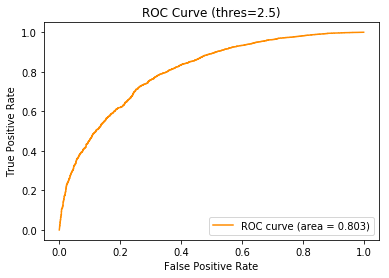

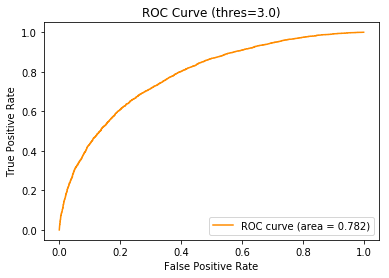

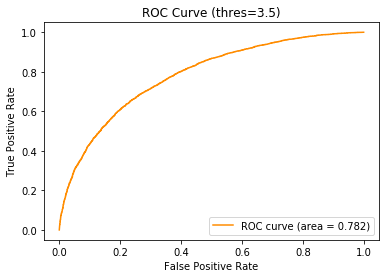

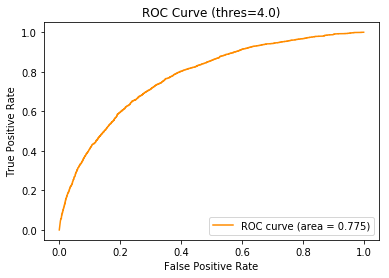

In [81]:
from sklearn import metrics
# Best k for MAE is index:  7   || best k-value:  16.0
# Best k for RMSE is index:  5  || best k-value:  12.0

data = Dataset.load_builtin('ml-100k')
kf = KFold(n_splits=10) # 90% for training and 10% for testing
trainset, testset = None, None
for train, test in kf.split(data): # just use the first split since we're not cross validating  (are we?)
    trainset, testset = train, test
    break
algo = KNNWithMeans(k=16, sim_options={'name': 'pearson_baseline'})
algo.fit(trainset)
pred = algo.test(testset)
# print(pred)

for thres in [2.5, 3, 3.5, 4]:
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    y_true, y_pred = [], []
    for u, i, r_real, r_pred, misc in pred:
        y_true.append(thres < r_real)
#         y_pred.append(thres < r_pred)
        y_pred.append(r_pred)

    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (thres=%.1f)' % thres)
    plt.legend(loc="lower right")
    plt.show()

    

# Question 16
## Is the optimization problem given by equation 5 convex? 
Considering U fixed, one can calculate the cost function's Hessian matrix by taking the double derviative with respect to V. This Hessian Matrix is shown to be positive semi-definite. Hence, the optimization problem given by equation 5 is convex.


# Question 17
Design a NNMF-based collaborative filter to predict the ratings of
the movies in the MovieLens dataset and evaluate it’s performance using 10-fold
cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes
of 2, and for each k compute the average RMSE and average MAE obtained
by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis).
For solving this question, use the default value for the regularization parameter.

In [89]:
from surprise import NMF

data = Dataset.load_builtin('ml-100k')
ks = np.linspace(2, 50, num=25)

outputs = []
for k in ks:
    algo = NMF(n_factors=int(k))
    outputs.append(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10))
    
avg_rmses = []
avg_maes = []
for output in outputs:
    avg_rmses.append(np.mean(output['test_rmse']))
    avg_maes.append(np.mean(output['test_mae']))
    
plotStats(avg_rmses=avg_rmses, avg_maes=avg_maes)

NameError: name 'plotStats' is not defined

# Question 18: Find minimum k
Use the plot from question 17, to find the optimal number of
latent factors. Optimal number of latent factors is the value of k that gives
the minimum average RMSE or the minimum average MAE. Please report the
minimum average RMSE and MAE. Is the optimal number of latent factors
same as the number of movie genres?

In [93]:
mae_idx = euclidean_elbow(ks, avg_maes)
print("Best k for MAE is index: ", mae_idx, "  || best k-value: ", ks[mae_idx])

rmse_idx = euclidean_elbow(ks, avg_rmses)
print("Best k for RMSE is index: ", rmse_idx, " || best k-value: ", ks[rmse_idx])

print("Minimum K = %d" % max(ks[mae_idx], ks[rmse_idx])) # 16

Best k for MAE is index:  6   || best k-value:  14.0
Best k for RMSE is index:  4  || best k-value:  10.0
Minimum K = 14


# Question 19: Popular Trim NNMF

popular trimmed 38 examples
RMSE: 1.2081
popular trimmed 43 examples
RMSE: 1.2192
popular trimmed 23 examples
RMSE: 1.2138
popular trimmed 17 examples
RMSE: 1.1950
popular trimmed 25 examples
RMSE: 1.2056
popular trimmed 38 examples
RMSE: 1.2058
popular trimmed 32 examples
RMSE: 1.2111
popular trimmed 25 examples
RMSE: 1.2110
popular trimmed 30 examples
RMSE: 1.2079
popular trimmed 34 examples
RMSE: 1.1995
popular trimmed 23 examples
RMSE: 1.0912
popular trimmed 32 examples
RMSE: 1.0851
popular trimmed 29 examples
RMSE: 1.0945
popular trimmed 28 examples
RMSE: 1.0957
popular trimmed 21 examples
RMSE: 1.0891
popular trimmed 29 examples
RMSE: 1.1045
popular trimmed 37 examples
RMSE: 1.0867
popular trimmed 33 examples
RMSE: 1.0898
popular trimmed 39 examples
RMSE: 1.0970
popular trimmed 24 examples
RMSE: 1.0894
popular trimmed 30 examples
RMSE: 1.0275
popular trimmed 36 examples
RMSE: 1.0298
popular trimmed 30 examples
RMSE: 1.0221
popular trimmed 26 examples
RMSE: 1.0354
popular trimmed 

RMSE: 0.9877
popular trimmed 45 examples
RMSE: 0.9981
popular trimmed 31 examples
RMSE: 1.0205
popular trimmed 32 examples
RMSE: 1.0223
popular trimmed 25 examples
RMSE: 1.0247
popular trimmed 26 examples
RMSE: 1.0229
popular trimmed 31 examples
RMSE: 1.0039
popular trimmed 14 examples
RMSE: 1.0126
popular trimmed 28 examples
RMSE: 1.0124
popular trimmed 31 examples
RMSE: 0.9975
popular trimmed 28 examples
RMSE: 0.9958
popular trimmed 29 examples
RMSE: 1.0161
popular trimmed 36 examples
RMSE: 1.0137
popular trimmed 36 examples
RMSE: 1.0173
popular trimmed 22 examples
RMSE: 1.0058
popular trimmed 28 examples
RMSE: 1.0287
popular trimmed 32 examples
RMSE: 1.0267
popular trimmed 25 examples
RMSE: 1.0161
popular trimmed 25 examples
RMSE: 1.0162
popular trimmed 24 examples
RMSE: 1.0049
popular trimmed 24 examples
RMSE: 1.0163
popular trimmed 33 examples
RMSE: 1.0187
popular trimmed 25 examples
RMSE: 1.0287
popular trimmed 29 examples
RMSE: 1.0241
popular trimmed 39 examples
RMSE: 1.0223
pop

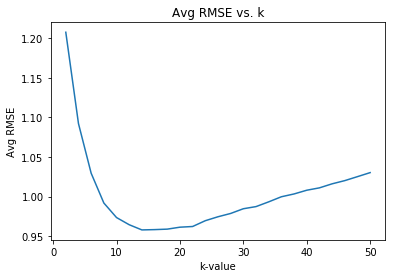

ValueError: invalid number of arguments

In [97]:
from surprise import NMF
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold

data = Dataset.load_builtin('ml-100k')
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = NMF(n_factors=int(k))
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(popularTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)
    
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.minimum(avgRmses))

# Question 20: Unpopular Trim NNMF

In [ ]:
data = Dataset.load_builtin('ml-100k')
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = NMF(n_factors=int(k))
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(unpopularTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)
    
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.minimum(avgRmses))

# Question 21: High Var Trim NNMF

In [ ]:
data = Dataset.load_builtin('ml-100k')
ks = np.linspace(2, 50, num=25)
kf = KFold(n_splits=10)

avgRmses = []
for k in ks:
    algo = NMF(n_factors=int(k))
    
    totalRMSE = 0
    totalMAE = 0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)

        predictions = algo.test(highVarTrim(trainset, testset))

        totalRMSE += accuracy.rmse(predictions)
        
    avgRmses.append(totalRMSE / 10.)
    
plotStats(avg_rmses=avgRmses)
print("Minimum avg rmse = %.4f" % np.minimum(avgRmses))

# Question 22
Plot the ROC curves for the NNMF-based collaborative filter
designed in question 17 for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting
use the optimal number of latent factors found in question 18. For each of
the plots, also report the area under the curve (AUC) value.

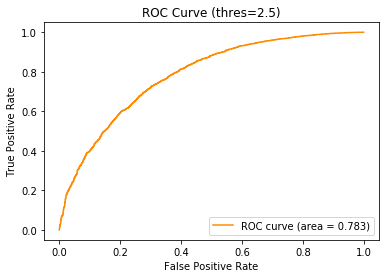

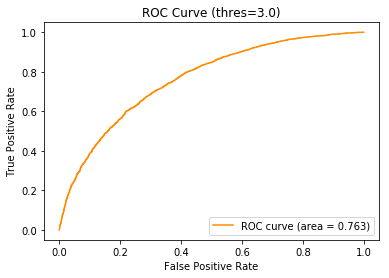

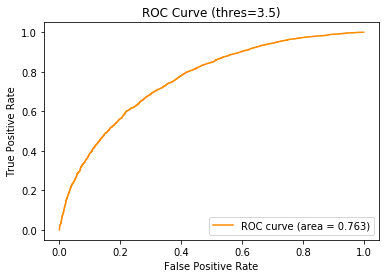

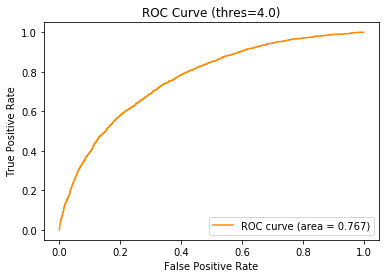

In [95]:
from sklearn import metrics

data = Dataset.load_builtin('ml-100k')
kf = KFold(n_splits=10) # 90% for training and 10% for testing
trainset, testset = None, None
for train, test in kf.split(data): # just use the first split since we're not cross validating  (are we?)
    trainset, testset = train, test
    break
algo = NMF(n_factors=14)
algo.fit(trainset)
pred = algo.test(testset)
# print(pred)

for thres in [2.5, 3, 3.5, 4]:
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    y_true, y_pred = [], []
    for u, i, r_real, r_pred, misc in pred:
        y_true.append(thres < r_real)
#         y_pred.append(thres < r_pred)
        y_pred.append(r_pred)

    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (thres=%.1f)' % thres)
    plt.legend(loc="lower right")
    plt.show()

    

# Question 23
Perform Non-negative matrix factorization on the ratings matrix
R to obtain the factor matrices U and V , where U represents the user-latent
factors interaction and V represents the movie-latent factors interaction (use k
= 20). For each column of V , sort the movies in descending order and report
the genres of the top 10 movies. Do the top 10 movies belong to a particular
or a small collection of genre? Is there a connection between the latent factors
and the movie genres?